# BA885 Team Project
#### Christian Lawrence, Tianzheng Mao, Tiam Moradi, Phoenix Wang

To access the dataset, please add the following shared folders to your working directory:
* https://tinyurl.com/3cn2zk8u (labeled images)
* https://tinyurl.com/ypaf8wtt (unlabeled images)

# Environment Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
import PIL.Image
import pathlib
import matplotlib.image as mpimg
from matplotlib import rcParams
from pathlib import Path
import pathlib

# Data Setup

In [2]:
# load all the labeled images
data_dir = pathlib.Path('Labeled')

## Preprocessing

Use 80% of the images for training and 20% for validation.

In [3]:
batch_size = 32
img_height = 150
img_width = 150

In [4]:
# generate training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 13628 files for training.


In [5]:
# generate validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 3406 files for validation.


Each batch contains 32 images of shape `(150, 150, 3)` and their corresponding labels.

In [6]:
# shape of each batch
image_batch, label_batch = next(iter(train_ds))
print(image_batch.shape)
print(label_batch.shape)

(32, 150, 150, 3)
(32,)


## Rescaling

The RGB channel values are in the `[0, 255]` range. We'll rescale the values to be in the `[0, 1]` range.

In [11]:
# value range from 0 to 255
image_batch, label_batch = next(iter(train_ds))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 255.0


In [12]:
standardization = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
train_ds = train_ds.map(lambda x, y: (standardization(x), y))
val_ds = val_ds.map(lambda x, y: (standardization(x), y))

In [13]:
# value range from 0 to 1
image_batch, label_batch = next(iter(train_ds))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 1.0


# Model Building and Training

In [14]:
# configure performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model tuning

In [15]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,8]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=8, max_value=16, step=2),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=8, max_value=16, step=2),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [17]:
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow import keras

In [20]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=10,directory='output',project_name="BA_885")

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.0001)
tuner_search.search(train_ds, validation_data=val_ds,epochs=5,callbacks=[stop_early])

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.7960000038146973

Best val_accuracy So Far: 0.7960000038146973
Total elapsed time: 00h 08m 55s
INFO:tensorflow:Oracle triggered exit


In [22]:
model=tuner_search.get_best_models(num_models=1)[0]

In [23]:
model.build(image_batch.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 148, 148, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 74, 74, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 70, 70, 48)          38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 35, 35, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 31, 31, 10)          12010     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 15, 15, 10)          0         
_________________________________________________________________
flatten (Flatten)            (32, 2250)                0

In [24]:
epochs = 10
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
439/439 [==============================] - 11s 24ms/step - loss: 0.5290 - accuracy: 0.8089 - val_loss: 0.5703 - val_accuracy: 0.7920
Epoch 2/10
439/439 [==============================] - 10s 24ms/step - loss: 0.4771 - accuracy: 0.8287 - val_loss: 0.5531 - val_accuracy: 0.8043
Epoch 3/10
439/439 [==============================] - 10s 24ms/step - loss: 0.4397 - accuracy: 0.8426 - val_loss: 0.5744 - val_accuracy: 0.8027
Epoch 4/10
439/439 [==============================] - 11s 24ms/step - loss: 0.4155 - accuracy: 0.8516 - val_loss: 0.5735 - val_accuracy: 0.8067
Epoch 5/10
439/439 [==============================] - 10s 24ms/step - loss: 0.3882 - accuracy: 0.8627 - val_loss: 0.5507 - val_accuracy: 0.8117
Epoch 6/10
439/439 [==============================] - 10s 24ms/step - loss: 0.3601 - accuracy: 0.8722 - val_loss: 0.5634 - val_accuracy: 0.8187
Epoch 7/10
439/439 [==============================] - 10s 24ms/step - loss: 0.3416 - accuracy: 0.8762 - val_loss: 0.5991 - val_accuracy:

In [26]:
import seaborn as sns

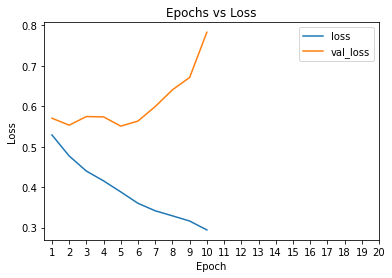

In [29]:
# Here is the code to visualize the loss values
sns.lineplot(x=range(1,11),y=history.history['loss'])
sns.lineplot(x=range(1,11),y=history.history['val_loss'])
plt.legend(loc='upper right',labels=['loss','val_loss'])
plt.title('Epochs vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.xticks(ticks=range(1,21));

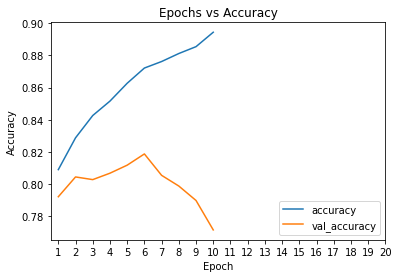

In [30]:
# Here is the code to visualize the accuracy values 
sns.lineplot(x=range(1,11),y=history.history['accuracy'])
sns.lineplot(x=range(1,11),y=history.history['val_accuracy'])
plt.legend(loc='lower right',labels=['accuracy','val_accuracy'])
plt.title('Epochs vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.xticks(ticks=range(1,21));

In [48]:
val_true_labels = []
val_pred_labels = []
for x , y in val_ds:
    y_pred = model.predict_on_batch(x)
    y_pred = np.argmax(y_pred,axis=1).tolist()
    val_pred_labels.extend(y_pred)
    # print(y)
    # y_ = np.argmax(y,axis=1).tolist()
    val_true_labels.extend(y)

tf.Tensor([5 3 5 2 1 2 2 4 0 4 3 1 2 4 0 5 5 0 0 4 0 5 5 0 0 2 3 1 2 4 0 0], shape=(32,), dtype=int32)
tf.Tensor([4 1 4 3 4 1 2 5 1 5 2 1 0 4 5 4 0 4 2 5 4 0 0 4 3 3 5 5 3 5 4 1], shape=(32,), dtype=int32)
tf.Tensor([0 5 5 5 0 4 1 4 5 2 0 2 5 3 5 2 2 0 2 1 4 2 3 2 2 0 1 4 0 0 3 3], shape=(32,), dtype=int32)
tf.Tensor([3 2 1 5 4 4 1 3 2 1 3 4 3 2 1 0 1 1 1 5 1 4 4 1 3 2 4 1 4 3 0 5], shape=(32,), dtype=int32)
tf.Tensor([3 3 3 0 0 1 5 3 4 1 2 2 2 5 0 5 5 4 0 4 1 2 1 0 5 1 2 3 4 3 0 4], shape=(32,), dtype=int32)
tf.Tensor([5 1 2 3 5 4 1 5 4 5 4 2 2 1 5 5 5 5 3 0 2 3 4 2 1 0 1 2 5 4 3 4], shape=(32,), dtype=int32)
tf.Tensor([3 4 3 5 2 1 3 3 0 4 2 1 3 2 0 5 2 0 5 1 2 4 2 5 0 0 2 1 2 4 3 5], shape=(32,), dtype=int32)
tf.Tensor([1 1 0 3 1 5 2 0 5 1 0 4 4 4 4 0 2 5 5 0 2 4 3 4 2 5 4 0 1 5 3 1], shape=(32,), dtype=int32)
tf.Tensor([2 4 3 3 0 1 0 5 1 0 3 3 4 1 0 3 5 3 1 0 2 5 0 1 4 1 5 2 0 3 3 0], shape=(32,), dtype=int32)
tf.Tensor([0 4 0 5 5 4 1 4 0 0 2 3 3 3 0 0 3 4 2 3 3 4 2 5 5 4 3 1 0 3 4 

tf.Tensor([3 4 3 4 5 2 1 2 3 1 1 4 4 1 5 5 2 1 4 2 3 5 0 3 0 2 2 4 4 1 0 3], shape=(32,), dtype=int32)
tf.Tensor([1 5 0 3 5 5 5 4 4 1 2 5 2 2 1 0 3 2 1 4 2 0 1 2 5 1 3 5 0 3 0 5], shape=(32,), dtype=int32)
tf.Tensor([3 0 2 3 4 0 2 5 1 2 2 4 2 4 5 2 4 3 0 0 0 0 5 4 0 5 1 1 5 5 5 1], shape=(32,), dtype=int32)
tf.Tensor([5 1 4 1 3 0 2 4 3 1 1 2 2 3 0 3 1 1 3 5 0 1 2 3 5 0 3 2 5 0 2 5], shape=(32,), dtype=int32)
tf.Tensor([0 5 5 2 2 4 4 2 5 2 3 5 3 4 0 0 2 3 4 2 3 2 1 4 4 1 4 1 0 3 4 2], shape=(32,), dtype=int32)
tf.Tensor([3 2 2 3 4 4 3 1 1 3 0 4 0 5 5 3 5 4 2 1 2 2 5 2 1 4 2 4 1 0 1 2], shape=(32,), dtype=int32)
tf.Tensor([3 1 2 4 3 4 2 2 4 5 2 1 1 1 5 2 4 2 5 2 2 4 3 5], shape=(24,), dtype=int32)


In [49]:
from sklearn.metrics import classification_report
print(classification_report(val_true_labels,val_pred_labels))

              precision    recall  f1-score   support

           0       0.59      0.90      0.72       437
           1       0.99      0.80      0.89       474
           2       0.70      0.86      0.77       553
           3       0.81      0.67      0.73       525
           4       0.88      0.76      0.82       510
           5       0.82      0.65      0.72       501

    accuracy                           0.77      3000
   macro avg       0.80      0.77      0.77      3000
weighted avg       0.80      0.77      0.77      3000

